In [1]:
from transformers import pipeline, set_seed

c:\Users\Alexey\venv\gpt2diy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
generator = pipeline('text-generation', model='gpt2')
set_seed(42)

Device set to use cuda:0


In [3]:
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5, truncation=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Hello, I\'m a language model, so I can write things that are easy to understand with help of my programming language."\n\nHowever, this'},
 {'generated_text': "Hello, I'm a language model, I've had years of experience with languages, but here I'm a native speaker. So I was kind of"},
 {'generated_text': "Hello, I'm a language model, I need to understand and understand languages.\n\nBut I don't necessarily think we can use language models to"},
 {'generated_text': 'Hello, I\'m a language model, this is a language model, and when somebody calls you, you don\'t hear this very often anyway," he'},
 {'generated_text': "Hello, I'm a language model, not a language model. I mean, the basic premise for modeling languages with Ocamlp is that each value"}]

In [4]:
hfgpt2_state = generator.model.state_dict()

In [5]:
for (k, v) in hfgpt2_state.items():
  print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [6]:
generator.model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [7]:
from dataclasses import dataclass
import torch
import torch.nn as nn

In [8]:
@dataclass
class GPT2Config:
  n_layers = 12
  n_embd = 768
  n_heads = 12
  block_size = 1024
  vocab_size = 50257

In [9]:
wpe = nn.Embedding(1024, 768)

In [10]:
wpe.weight.data = hfgpt2_state['transformer.wpe.weight'].data

In [11]:
# Block attention and projection (c_attn and c_proj) are Conv1D modules with weight and bias
# if we want to use Linear, that would require transpose of loaded weights.

In [12]:
c_attn = nn.Linear(768, 768*3, bias=True, device='cuda') # query, key, values weights in single matrix
c_attn.bias.data = generator.model.transformer.h[0].attn.c_attn.bias.data
c_attn.weight.data = generator.model.transformer.h[0].attn.c_attn.weight.data.T

In [13]:
x = torch.randn((4, 6, 768), device='cuda')

In [14]:
out_hf = generator.model.transformer.h[0].attn.c_attn(x)

In [15]:
out_loc = c_attn(x)

In [16]:
(out_hf == out_loc).all()

tensor(True, device='cuda:0')

In [17]:
generator.model.transformer.h[0].attn

GPT2Attention(
  (c_attn): Conv1D(nf=2304, nx=768)
  (c_proj): Conv1D(nf=768, nx=768)
  (attn_dropout): Dropout(p=0.1, inplace=False)
  (resid_dropout): Dropout(p=0.1, inplace=False)
)

In [18]:
qkv = torch.randn((4, 8, 12))
q,k,v = torch.split(qkv, 4, dim=-1)

In [19]:
v.shape

torch.Size([4, 8, 4])

## Load our model weights from pretrained

In [ ]:
import torch
from transformers import GPT2LMHeadModel

from train_gpt2 import GPT2, GPT2Config

In [102]:
hf_model = GPT2LMHeadModel.from_pretrained('gpt2')
hf_model.to('cuda')

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [103]:
generator = pipeline('text-generation', model='gpt2')
set_seed(42)

Device set to use cuda:0


In [111]:
# same model
for ((ak, av), (bk, bv)) in zip(hf_model.state_dict().items(), generator.model.state_dict().items()):
  if ak != bk:
    print(f'{ak=} != {bk=}')
  if torch.any(av != bv):
    print(f'{ak} weight != {bk} weight')

In [105]:
conf = GPT2Config()
model = GPT2(conf)
model.to('cuda')
model.eval()

GPT2(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='tanh')
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [106]:
for name in model.state_dict():
  if name not in generator.model.state_dict():
    print(f'{name=} not in HF model')
    
for name in generator.model.state_dict():
  if name not in model.state_dict():
    print(f'{name=} not in our model')

In [107]:
model.state_dict().keys() == hf_model.state_dict().keys()

True

In [108]:
for name in model.state_dict():
  if "c_" in name and name.endswith("weight"):
    print(name)

transformer.h.0.attn.c_attn.weight
transformer.h.0.attn.c_proj.weight
transformer.h.0.mlp.c_fc.weight
transformer.h.0.mlp.c_proj.weight
transformer.h.1.attn.c_attn.weight
transformer.h.1.attn.c_proj.weight
transformer.h.1.mlp.c_fc.weight
transformer.h.1.mlp.c_proj.weight
transformer.h.2.attn.c_attn.weight
transformer.h.2.attn.c_proj.weight
transformer.h.2.mlp.c_fc.weight
transformer.h.2.mlp.c_proj.weight
transformer.h.3.attn.c_attn.weight
transformer.h.3.attn.c_proj.weight
transformer.h.3.mlp.c_fc.weight
transformer.h.3.mlp.c_proj.weight
transformer.h.4.attn.c_attn.weight
transformer.h.4.attn.c_proj.weight
transformer.h.4.mlp.c_fc.weight
transformer.h.4.mlp.c_proj.weight
transformer.h.5.attn.c_attn.weight
transformer.h.5.attn.c_proj.weight
transformer.h.5.mlp.c_fc.weight
transformer.h.5.mlp.c_proj.weight
transformer.h.6.attn.c_attn.weight
transformer.h.6.attn.c_proj.weight
transformer.h.6.mlp.c_fc.weight
transformer.h.6.mlp.c_proj.weight
transformer.h.7.attn.c_attn.weight
transformer.h

In [109]:
with torch.no_grad():
  self_sd = model.state_dict()
  hf_sd = hf_model.state_dict()
  wn = "transformer.h.0.attn.c_attn.weight"
  bn = "transformer.h.0.attn.c_attn.bias"
  self_sd[wn].copy_(hf_sd[wn].T)
  self_sd[bn].copy_(hf_sd[bn])
  

In [110]:
(model.state_dict()[wn] == hf_model.state_dict()[wn].T).all(),\
  (model.state_dict()[bn] == hf_model.state_dict()[bn]).all()

(tensor(True, device='cuda:0'), tensor(True, device='cuda:0'))

In [ ]:
import torch.nn as nn

In [74]:
class Net(nn.Module):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.net = nn.Linear(3,4)
  def forward(self, x):
    return self.net(x)

  @classmethod
  def from_pretrained(cls):
    n = cls()
    n.state_dict()['net.weight'].copy_(nn.Linear(3,4).weight)
    n.state_dict()['net.bias'].copy_(nn.Linear(3,4).bias)
    return n

In [75]:
net = Net.from_pretrained()

In [76]:
net

Net(
  (net): Linear(in_features=3, out_features=4, bias=True)
)

## Generate

In [ ]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel
import tiktoken

from train_gpt2 import GPT2, GPT2Config

c:\Users\Alexey\venv\gpt2diy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using device='cuda'


In [2]:
# generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5, truncation=True)

In [11]:
text = "Hello, I'm a language model,"

In [12]:
tokenizer = tiktoken.get_encoding("gpt2")

In [13]:
ids = tokenizer.encode(text)

In [14]:
tokenizer.decode(ids) == text

True

In [7]:
hf_model = GPT2LMHeadModel.from_pretrained('gpt2')
hf_model.to('cuda')
hf_model.eval()


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [8]:
model = GPT2.from_pretrained(GPT2Config())
model.to('cuda')
model.eval()

GPT2(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='tanh')
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [18]:
t = torch.randn((5, 20)).softmax(-1)
vals, ixs = torch.topk(t, k=10)

In [25]:
t

tensor([[0.1074, 0.0987, 0.0424, 0.0070, 0.0723, 0.0848, 0.0841, 0.0273, 0.0306,
         0.0115, 0.0291, 0.0377, 0.0322, 0.0375, 0.0079, 0.0241, 0.0198, 0.0543,
         0.1079, 0.0834],
        [0.0369, 0.0419, 0.0563, 0.0368, 0.1469, 0.0543, 0.1494, 0.1152, 0.0404,
         0.0266, 0.0274, 0.0527, 0.0349, 0.0246, 0.0242, 0.0060, 0.0054, 0.0808,
         0.0290, 0.0104],
        [0.0815, 0.0420, 0.0076, 0.0069, 0.0606, 0.0147, 0.0071, 0.0807, 0.0251,
         0.0170, 0.0118, 0.0586, 0.1599, 0.0285, 0.1813, 0.0691, 0.0349, 0.0492,
         0.0288, 0.0347],
        [0.0160, 0.0856, 0.0332, 0.0065, 0.0079, 0.0798, 0.0310, 0.0794, 0.0087,
         0.0211, 0.0387, 0.0032, 0.0691, 0.0274, 0.0174, 0.2883, 0.0409, 0.0555,
         0.0734, 0.0169],
        [0.1487, 0.0284, 0.0162, 0.0301, 0.0807, 0.0458, 0.0545, 0.0071, 0.0701,
         0.0557, 0.1318, 0.0150, 0.0155, 0.0066, 0.0322, 0.0108, 0.0027, 0.0280,
         0.2086, 0.0114]])

In [19]:
vals, ixs

(tensor([[0.1079, 0.1074, 0.0987, 0.0848, 0.0841, 0.0834, 0.0723, 0.0543, 0.0424,
          0.0377],
         [0.1494, 0.1469, 0.1152, 0.0808, 0.0563, 0.0543, 0.0527, 0.0419, 0.0404,
          0.0369],
         [0.1813, 0.1599, 0.0815, 0.0807, 0.0691, 0.0606, 0.0586, 0.0492, 0.0420,
          0.0349],
         [0.2883, 0.0856, 0.0798, 0.0794, 0.0734, 0.0691, 0.0555, 0.0409, 0.0387,
          0.0332],
         [0.2086, 0.1487, 0.1318, 0.0807, 0.0701, 0.0557, 0.0545, 0.0458, 0.0322,
          0.0301]]),
 tensor([[18,  0,  1,  5,  6, 19,  4, 17,  2, 11],
         [ 6,  4,  7, 17,  2,  5, 11,  1,  8,  0],
         [14, 12,  0,  7, 15,  4, 11, 17,  1, 16],
         [15,  1,  5,  7, 18, 12, 17, 16, 10,  2],
         [18,  0, 10,  4,  8,  9,  6,  5, 14,  3]]))

In [21]:
smpl = torch.multinomial(vals, num_samples=1)

In [24]:
smpl

tensor([[0],
        [6],
        [6],
        [5],
        [9]])

In [23]:
torch.gather(ixs, -1, smpl)

tensor([[18],
        [11],
        [11],
        [12],
        [ 3]])

In [26]:
inp = torch.LongTensor(ids) # convert to torch tensor
inp.unsqueeze_(0) # add batch dimension
inp = inp.repeat(5, 1) # batch of 5 same inputs
inp = inp.to('cuda') # move to gpu

max_new_tokens = 50
torch.manual_seed(42)
for _ in range(max_new_tokens):
  with torch.no_grad():
    # clamp input to block size from left
    logits = hf_model(inp[:,-1024:]).logits # model returns some output object, we need only logits
    # only need probs for the last time step
    logits = logits[:, -1, :]
    probs = torch.softmax(logits, -1)
    topk_vals, topk_ids = torch.topk(probs, k=50) # topk_ids are indices of original tensor `probs`
    topk_sample = torch.multinomial(topk_vals, num_samples=1) # topk_sample are indices of tensor `topk_vals`
    new_id = torch.gather(topk_ids, -1, topk_sample) # map sampled ids to original `probs` ids
    inp = torch.cat((inp, new_id), dim=-1) 

out = tokenizer.decode_batch(inp.data.tolist())
for res in out:
  print(res)
  print('------------')

Hello, I'm a language model, not a program.

So this morning I started studying for the interview in the lab. This was not a hard question, I decided to do it before I knew what I was doing. The goal is this: I wanted to see if my
------------
Hello, I'm a language model, and one of the main things that bothers me when they create languages is how easy it becomes to create something that is difficult to understand. I find myself more confused about how to understand than I normally am. And because of that, I try to work
------------
Hello, I'm a language model, and I wrote it off on the grounds that a language model would make me more fluent. But I'm not sure if that's true.

But let's go back to your question about learning a language through formal procedures and procedures.


------------
Hello, I'm a language model, I really like languages. I like languages because like, they're good. And the way we talk about languages and, you know, we tend to do things like this. And because I w

In [27]:
inp = torch.LongTensor(ids) # convert to torch tensor
inp.unsqueeze_(0) # add batch dimension
inp = inp.repeat(5, 1) # batch of 5 same inputs
inp = inp.to('cuda') # move to gpu

max_new_tokens = 50
torch.manual_seed(42)
for _ in range(max_new_tokens):
  with torch.no_grad():
    # clamp input to block size from left
    logits = model(inp[:,-1024:])
    # only need probs for the last time step
    logits = logits[:, -1, :]
    probs = torch.softmax(logits, -1)
    topk_vals, topk_ids = torch.topk(probs, k=50) # topk_ids are indices of original tensor `probs`
    topk_sample = torch.multinomial(topk_vals, num_samples=1) # topk_sample are indices of tensor `topk_vals`
    new_id = torch.gather(topk_ids, -1, topk_sample) # map sampled ids to original `probs` ids
    inp = torch.cat((inp, new_id), dim=-1) 

out = tokenizer.decode_batch(inp.data.tolist())
for res in out:
  print(res)
  print('------------')

Hello, I'm a language model, not a program.

So this morning I started studying for the interview in the lab. This was not a hard question, I decided to do it before I knew what I was doing. The goal is this: I wanted to see if my
------------
Hello, I'm a language model, and one of the main things that bothers me when they create languages is how easy it becomes to create something that is difficult to understand. I find myself more confused about how to understand than I normally am. And because of that, I try to work
------------
Hello, I'm a language model, and I wrote it off on the grounds that a language model would make me more fluent. But I'm not sure if that's true.

But let's go back to your question about learning a language through formal procedures and procedures.


------------
Hello, I'm a language model, I really like languages. I like languages because like, they're good. And the way we talk about languages and, you know, we tend to do things like this. And because I w

It is not exactly clear, where the difference is coming from. I quickly checked HF Conv1d and torch Linear\
they produce identical results. We are satisfied with allclose == True for now. Generate give identical results for both models.

## Data (tiny Shakespeare)

In [28]:
with open('input.txt', 'r', encoding='utf-8') as file:
  text = file.read()

In [29]:
len(text)

1115394

In [31]:
print(text[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [32]:
tokens = tokenizer.encode(text)

In [36]:
tokenizer.decode(tokens) == text

True

In [33]:
len(tokens)

338025

In [44]:
print(tokens[:21])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461]


In [41]:
tokens_t = torch.LongTensor(tokens)

We can use view to build training examples batches

In [43]:
tokens_t[:20].view(4, 5)

tensor([[ 5962, 22307,    25,   198,  8421],
        [  356,  5120,   597,  2252,    11],
        [ 3285,   502,  2740,    13,   198],
        [  198,  3237,    25,   198,  5248]])

In [45]:
tokens_t[1:21].view(4, 5)

tensor([[22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285],
        [  502,  2740,    13,   198,   198],
        [ 3237,    25,   198,  5248,   461]])

## Tieing Weights

In [1]:
import torch

In [98]:
torch.manual_seed(42)

x = torch.LongTensor([[0, 4, 8], [1, 3, 5]])

# md = torch.nn.ModuleDict({'emb' : torch.nn.Embedding(16, 8)}
emb = torch.nn.Embedding(16, 8)
lin = torch.nn.Linear(8, 16, bias=False)

In [94]:
lin.weight.shape, emb.weight.shape

(torch.Size([16, 8]), torch.Size([16, 8]))

In [95]:
out = lin(emb(x))
out

tensor([[[ 0.2254,  0.0222,  0.3604,  0.6448,  1.1176,  0.1838,  0.6554,
           0.9433,  0.8894, -0.0659, -0.6811,  0.0245, -0.5030,  1.6213,
           0.4703,  1.2801],
         [-0.3522,  1.0057,  0.8363, -0.0427, -1.2728,  0.2057, -0.3111,
          -0.5370, -0.7459,  0.9924, -0.0058, -0.4318,  0.2198, -0.1054,
          -0.4591, -0.1842],
         [ 0.8780, -1.0447,  0.4080, -0.0285,  1.0897, -0.3151, -0.0769,
           0.5778,  0.5107,  0.0160,  0.9507,  0.1982,  0.9791,  0.9064,
           0.2165, -0.6561]],

        [[-0.5602, -0.6276, -0.5666, -0.6105,  0.5836, -0.3182,  0.4591,
           0.2175,  0.4741, -0.2269,  0.6160,  0.0339,  1.1651,  0.2983,
           0.3716,  0.8153],
         [ 0.6085, -1.2056,  0.2706, -0.7742,  0.3890, -0.3874, -0.5874,
           0.4231,  0.6177, -0.4370,  0.7345, -0.1004,  0.5338,  0.6168,
          -0.1914, -0.5218],
         [ 0.2216, -0.9242, -1.2047, -0.3560, -0.5258, -0.2851,  0.7616,
           0.1467, -0.1758,  0.0170, -0.1492,  0.8

In [96]:
lin.weight = emb.weight

In [97]:
out = lin(emb(x))
out

tensor([[[15.7307,  2.6111, -3.0232,  0.5548, -5.8108, -3.6962, -4.3623,
          -8.6428,  3.4281,  2.0828, -0.8739, -2.4794, -3.0725, -0.1534,
          -4.9541, -1.5239],
         [-5.8108, -3.5381, -3.0255, -1.5793,  6.6510, -0.8536,  2.3842,
           0.8380, -3.4622,  0.8643, -0.1686,  0.4967,  3.5553, -0.4045,
           2.7248,  1.1969],
         [ 3.4281,  0.3635,  2.1911,  6.2868, -3.4622, -3.8462, -1.9225,
           0.8351, 10.9200,  2.2416, -4.6095, -2.5725, -3.0469,  0.8221,
          -1.9539,  0.9607]],

        [[ 2.6111,  7.4234, -1.3059,  0.0566, -3.5381,  4.3192, -1.4130,
           1.1963,  0.3635,  1.4369, -0.7406, -0.7301,  0.3878, -0.1645,
           0.6148, -1.9451],
         [ 0.5548,  0.0566,  3.6412,  6.3291, -1.5793, -1.7662, -1.5380,
           0.7021,  6.2868,  0.8119, -2.3700,  0.9370, -2.8397,  0.9553,
          -1.3380,  1.3302],
         [-3.6962,  4.3192, -1.0973, -1.7662, -0.8536, 12.4448,  4.8983,
           6.6989, -3.8462,  1.4792,  0.1735, -2.5

In [ ]:
lin.weight.data_ptr() == emb.weight.data_ptr()

True

In [ ]:
torch.all(lin.weight == emb.weight)

tensor(True)

## Motivation for Scaling Projections (weights) Feeding into Residual Stream

In [ ]:
import math
import torch

In [19]:
torch.manual_seed(42)
lin = torch.nn.Linear(768,768)
ln = torch.nn.LayerNorm(768)
x = torch.randn(8, 768)

print(x.mean(), x.std())

tensor(-0.0242) tensor(0.9970)


In [20]:
for _ in range(24):
  x += lin(ln(x))

print(x.mean(), x.std())

tensor(-0.1061, grad_fn=<MeanBackward0>) tensor(12.2625, grad_fn=<StdBackward0>)


In [21]:
torch.manual_seed(42)
lin = torch.nn.Linear(768,768)
ln = torch.nn.LayerNorm(768)
x = torch.randn(8, 768)

print(x.mean(), x.std())

tensor(-0.0242) tensor(0.9970)


In [22]:
scale = 1 / math.sqrt(24)
for _ in range(24):
  x += lin(ln(x)) * scale

print(x.mean(), x.std())

tensor(-0.0240, grad_fn=<MeanBackward0>) tensor(2.7736, grad_fn=<StdBackward0>)


In [ ]:
# The snippet above shows, that even having LayerNorm before projection adds its output
# to the residual stream is still not enough to keep layer variance reasonable.
# Best case, the network would need to learn to adjust weights accordingly ->
# potentially slowing down learning. Worst case, we can destabilize learning this way.

## Learning Rate Schedule

In [41]:
import math
from matplotlib import pyplot as plt

In [48]:
max_lr = 3e-4
max_steps = 1000
warmup_steps = max_steps // 10 # gpt-3 paper warmup is 375m/300b tokens, roughly 10%
decay_steps = max_steps - warmup_steps

In [49]:
# warmup steps
warmup_lrs = []
for step in range(warmup_steps):
  warmup_lrs.append(max_lr * (step + 1) / warmup_steps)

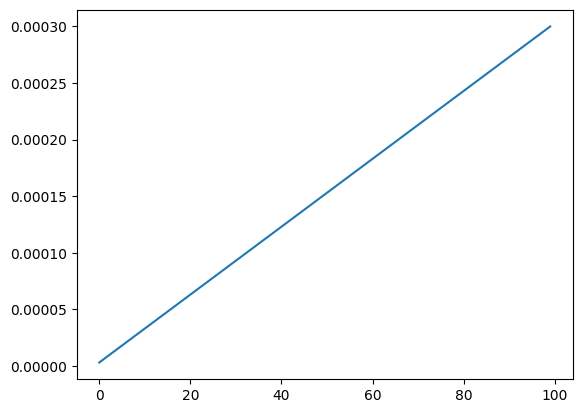

In [50]:
plt.plot(warmup_lrs);

In [51]:
decay_lrs = []
for step in range(decay_steps):
  lr = 0.5 * max_lr * (1 + math.cos(math.pi * (step / decay_steps)))
  decay_lrs.append(lr)

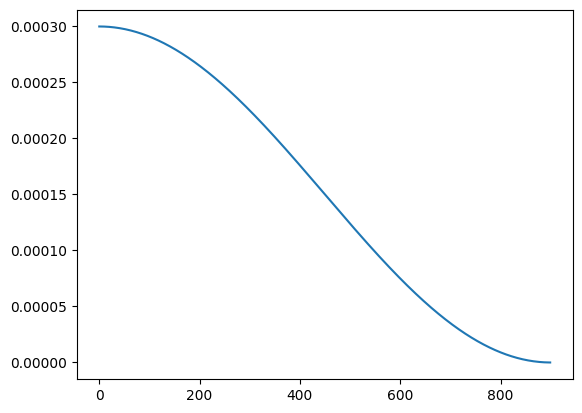

In [52]:
plt.plot(decay_lrs)

In [53]:
def get_lr(step, total_steps, max_lr):
  """Simple impl of cosine lr decay with
  linear warmup during first 10% of steps"""
  warmup_steps = total_steps // 10
  decay_steps = total_steps - warmup_steps
  if step < warmup_steps:
    return max_lr * (step + 1) / warmup_steps
  else:
    t = step - warmup_steps
    return 0.5 * max_lr * (1 + math.cos(math.pi * (t / decay_steps)))

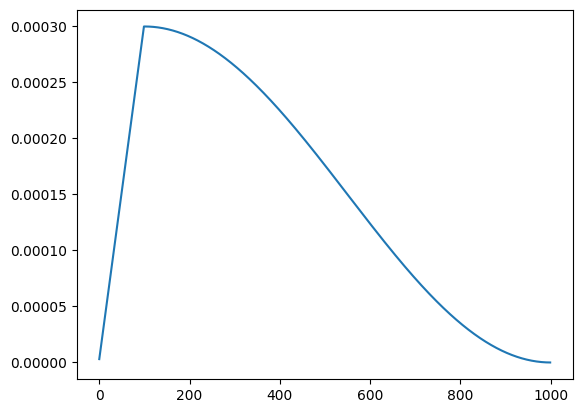

In [54]:
lrs = [get_lr(i, max_steps, max_lr) for i in range(max_steps)]
plt.plot(lrs)

In [55]:
lrs[-1]

9.138513314410623e-10